In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from tqdm import tqdm
%matplotlib inline

GPU acceleration enabled


In [2]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [3]:
def mu_to_mpc(mu):
    return np.power(10., 0.2*(mu-25.))

In [4]:
mu_to_mpc(25.)

1.0

In [5]:
plt.style.use('seaborn-poster')


In [6]:
f_m49 = ppy.instrument.default_m49_filters()
f_m49[0]._exposure, f_m49[1]._exposure

(560.0, 375.0)

In [7]:
f_m49

In [8]:
f_m31 = [f() for f in ppy.instrument.m31_filter_sets]
f_m31[0]._exposure, f_m31[1]._exposure

(1360.0, 3620.0)

In [9]:
f_m31

In [12]:
mu_to_mpc(31.3)

18.197008586099845

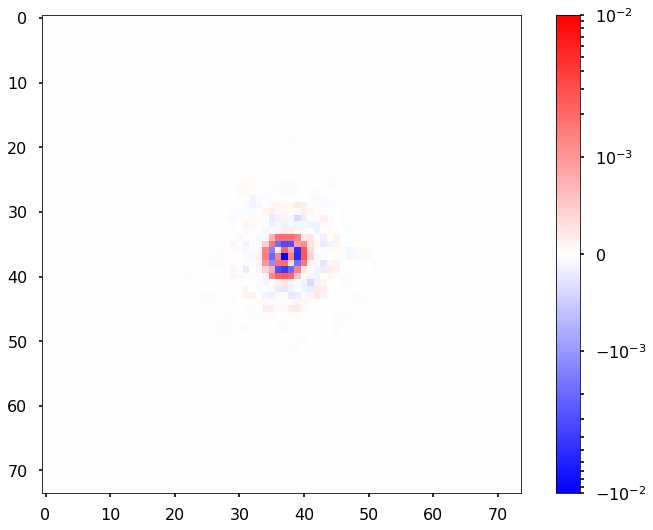

In [23]:
plt.imshow(f_m49[0]._psf[0,0] - f_m31[0]._psf[0,0], norm=mpl.colors.SymLogNorm(0.001, vmin=-1e-2, vmax=1e-2), cmap='bwr')
plt.colorbar()

In [24]:
%%time
isoc_m49 = ppy.isochrones.Isochrone_Model(f_m49)
isoc_m31 = ppy.isochrones.Isochrone_Model(f_m31)

CPU times: user 23.6 s, sys: 4.61 s, total: 28.2 s
Wall time: 30.8 s


In [25]:
driv_m49 = ppy.driver.Driver(isoc_m49)
driv_m31 = ppy.driver.Driver(isoc_m31)

In [26]:
pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t48_z-gz.pcmd', unpack=True)
pcmd_m31 = np.loadtxt('../data/m31_bulge_M2.dat', unpack=True)

# m31 data is in AB absolute mags
dmod_m49 = 31.3
dmod_m31 = 24.4
pcmd_m31[0] += dmod_m31

In [13]:
pcmd_m49, pcmd_m31

(array([[24.487806, 24.425386, 24.438587, ..., 24.561739, 24.603708,
         24.417299],
        [ 2.068798,  2.10301 ,  2.062786, ...,  2.004013,  1.966515,
          2.170784]]),
 array([[25.346939, 25.246066, 25.159676, ..., 25.082892, 25.172867,
         25.150114],
        [ 1.28262 ,  1.29257 ,  1.26145 , ...,  1.21849 ,  1.21187 ,
          1.22276 ]]))

In [29]:
gal_m49_var = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)

In [30]:
gal_m31 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.FixedDistance(dmod_m31)
)
gal_m49 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.FixedDistance(dmod_m49)
)

In [92]:
sky_m49 = np.array([30.0, 27.6])*1.

In [93]:
f_m49[0]._exposure = 560. * 1.
f_m49[1]._exposure = 375. * 1.

In [158]:
f_m31[0]._exposure = 1360.0 * 1.
f_m31[1]._exposure = 3620.0 * 1.

In [159]:
psf = True
shot_noise = True
psf_first = False

In [160]:
%%time
gal_m49.set_params(np.array([0., -1.5, 5.0, 1.5]))
pcmd_sim_m49 = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=shot_noise, sky_noise=sky_m49, psf=psf, psf_first=False)[0]

CPU times: user 1.55 s, sys: 365 ms, total: 1.92 s
Wall time: 2.6 s


In [161]:
%%time
pcmd_sim_m49_v1 = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=False, sky_noise=sky_m49*0., psf=False, psf_first=False)[0]

CPU times: user 1.29 s, sys: 329 ms, total: 1.62 s
Wall time: 2.06 s


In [162]:
%%time
pcmd_sim_m49_v2 = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=False, sky_noise=sky_m49*0., psf=True, psf_first=False)[0]

CPU times: user 1.49 s, sys: 339 ms, total: 1.83 s
Wall time: 2.27 s


In [162]:
%%time
pcmd_sim_m49_v2_alt = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49, psf=True, psf_first=False)[0]

CPU times: user 1.49 s, sys: 339 ms, total: 1.83 s
Wall time: 2.27 s


In [163]:
%%time
pcmd_sim_m49_v3 = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=False, sky_noise=sky_m49, psf=False, psf_first=True)[0]

CPU times: user 1.47 s, sys: 354 ms, total: 1.83 s
Wall time: 2.27 s


In [164]:
%%time
pcmd_sim_m49_v4 = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49, psf=False, psf_first=True)[0]

CPU times: user 1.57 s, sys: 329 ms, total: 1.9 s
Wall time: 2.35 s


In [165]:
%%time
gal_m31.set_params(np.array([0.2, -.6, 2.6, 2.]))
pcmd_sim_m31 = driv_m31.simulate(gal_m31, 512, downsample=5, shot_noise=shot_noise, system='ab', psf=psf, psf_first=psf_first)[0]

CPU times: user 1.23 s, sys: 311 ms, total: 1.54 s
Wall time: 1.98 s


In [166]:
%%time
pcmd_sim_m31_psffirst = driv_m31.simulate(gal_m31, 512, downsample=5, shot_noise=shot_noise, system='ab', psf=psf, psf_first=True)[0]

CPU times: user 1.25 s, sys: 286 ms, total: 1.53 s
Wall time: 1.99 s


In [167]:
f_m31[0]._exposure = 1360.0 * .1
f_m31[1]._exposure = 3620.0 * .1

In [168]:
%%time
pcmd_sim_m31_lowexp = driv_m31.simulate(gal_m31, 512, downsample=5, shot_noise=shot_noise, system='ab', psf=psf, psf_first=psf_first)[0]

CPU times: user 1.27 s, sys: 280 ms, total: 1.55 s
Wall time: 1.98 s


In [169]:
%%time
pcmd_sim_m31_psffirst_lowexp = driv_m31.simulate(gal_m31, 512, downsample=5, shot_noise=shot_noise, system='ab', psf=psf, psf_first=True)[0]

CPU times: user 1.26 s, sys: 272 ms, total: 1.53 s
Wall time: 1.98 s


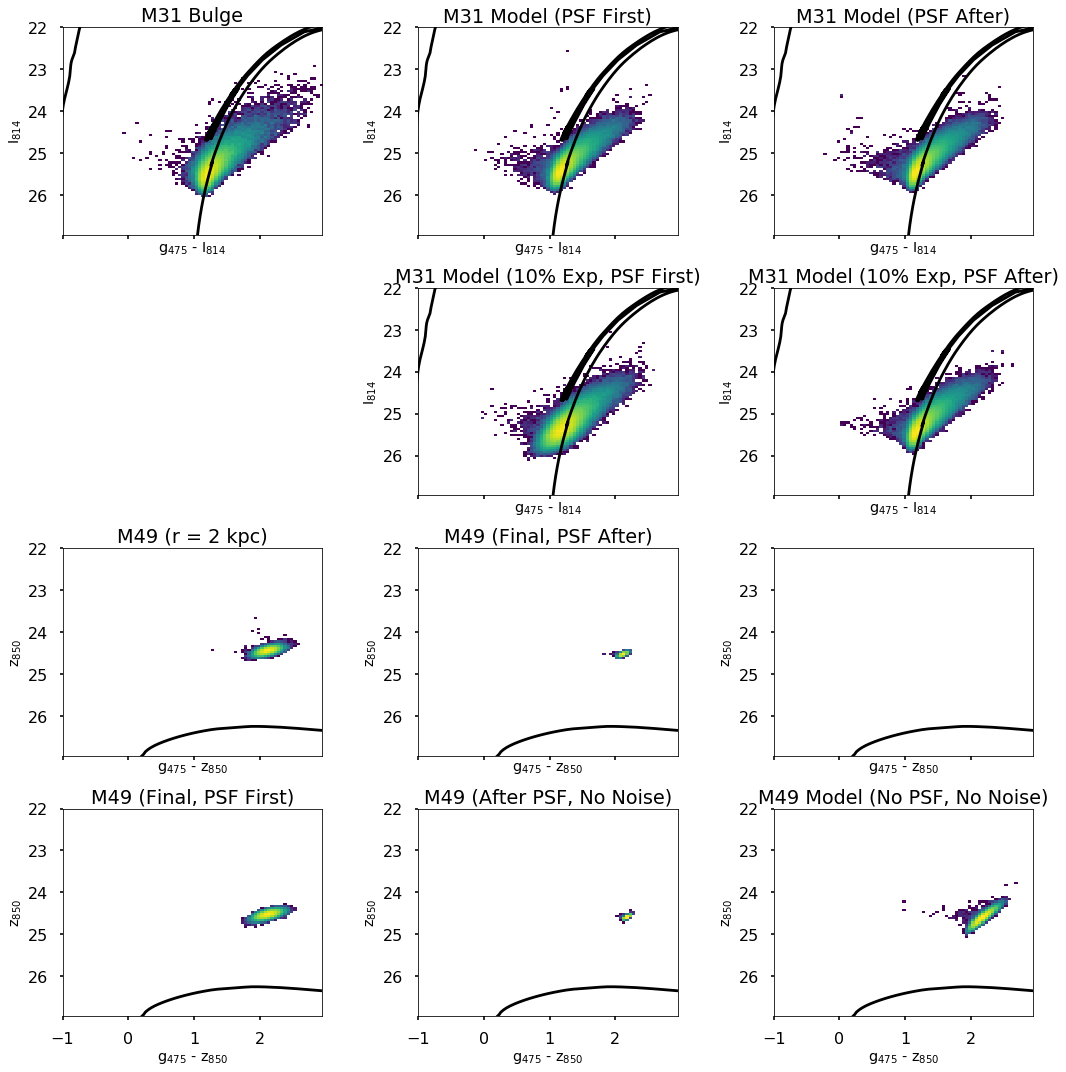

In [170]:
fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, sharey='col', figsize=(15, 15))
bins = [np.arange(-1, 3, 0.05), np.arange(22, 27, 0.05)]

ax = axes[0,0]
ax.hist2d(pcmd_m31[1], pcmd_m31[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Bulge')

ax = axes[0,1]
ax.hist2d(pcmd_sim_m31_psffirst[1], pcmd_sim_m31_psffirst[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Model (PSF First)')

ax = axes[0,2]
ax.hist2d(pcmd_sim_m31[1], pcmd_sim_m31[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Model (PSF After)')

axes[1,0].axis("off")

ax = axes[1,1]
ax.hist2d(pcmd_sim_m31_psffirst_lowexp[1], pcmd_sim_m31_psffirst_lowexp[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Model (10% Exp, PSF First)')

ax = axes[1,2]
ax.hist2d(pcmd_sim_m31_lowexp[1], pcmd_sim_m31_lowexp[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Model (10% Exp, PSF After)')


ax = axes[2,0]
ax.hist2d(pcmd_m49[1], pcmd_m49[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M49 (r = 2 kpc)')

ax = axes[2,1]
ax.hist2d(pcmd_sim_m49[1], pcmd_sim_m49[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title(r'M49 (Final, PSF After)')

ax = axes[3,2]
ax.hist2d(pcmd_sim_m49_v1[1], pcmd_sim_m49_v1[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title(r'M49 Model (No PSF, No Noise)')

ax = axes[3,1]
ax.hist2d(pcmd_sim_m49_v2[1], pcmd_sim_m49_v2[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title(r'M49 (After PSF, No Noise)')

ax = axes[3,0]
ax.hist2d(pcmd_sim_m49_v4[1], pcmd_sim_m49_v4[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title(r'M49 (Final, PSF First)')

for a in list(axes[0])+list(axes[1,1:]):
    ppy.plotting.plot_isochrone(isoc_m31, dmod=dmod_m31, axes=a, system='ab')
for a in axes[2:].flatten():
    ppy.plotting.plot_isochrone(isoc_m49, dmod=dmod_m49, axes=a)
    
plt.tight_layout()